# deepstatemap.live territorial gains scraping

Get the total area marked as "occupied" for each timestamp and compute the area in square kilometers using [GeoPandas](https://geopandas.org/).

**TODO:** Detection especially around May 2022 is faulty and the data only starts on 2022/04.

To run this notebook, you need to install a few packages via `pip`:
```
pip install geopandas pandas numpy
```
For ipyleaflet: `pip install ipyleaflet`

In [1]:
import datetime
import json
import os
import pathlib
import socket
import time

from multiprocessing.pool import ThreadPool
from urllib import request
from urllib.error import HTTPError, URLError

import geopandas as gpd
import pandas as pd
from shapely.geometry import shape

# ipyleaflet inline integration doesn't work atm?
# from ipyleaflet import Map, GeoJSON

In [2]:
USER_AGENT = 'deepstate-scraper/0.0.1'
TIMEOUT = 60
MAX_RETRIES = 10
COOLDOWN = 2  # 5 seconds between retries/after each download
PARALLEL_DOWNLOADS = 10
PARALLEL_PROCESSES = 16

HISTORY_URL = 'https://deepstatemap.live/api/history/'
# https://deepstatemap.live/api/history/1677196268/geojson

ITEMS_FOLDER = 'items'

# features[].properties.name
OCCUPIED_KEYS = [
    'Окупований Крим /// Occupied Crimea',
    'Окуповано /// Occupied',
    'ОРДЛО /// CADR and CALR',
    'Окуповано',
]
# Possible erroneous data:
# 'Окуп��вано /// Occupied',  # 2022-10-20 23:22:57 1666300977
# 'Ок��повано /// Occupied',  # 2022-08-07 19:05:38 1659891938
# 'Окуповано/// Occupied',  # 2022-08-07 19:05:38 1659891938
# 'Окупов��но /// Occupied',  # 2023-02-16 00:00:21 1676502021
# To quickly compare two items to see what's "off":
# meld \
#     <(cat items/1676502021.json | jq ".features[].properties.name") \
#     <(cat items/1676417652.json | jq ".features[].properties.name")

In [3]:
def scrape_json(url: str):
    headers = {
        'Content-Type': 'application/json',
        'User-Agent': USER_AGENT,
    }
    req = request.Request(
        url=url,
        headers=headers,
        method='GET',
    )

    def fetch():
        return json.loads(
            request.urlopen(
                req,
                timeout=TIMEOUT,
            ).read().decode('utf-8')
        )
    r = 0
    while r < MAX_RETRIES:
        try:
            return fetch()
        except HTTPError as e:
            r += 1
            print(f"HTTPError, retrying. e={e}")
            time.sleep(60)
            continue
        except URLError as e:
            r += 1
            if isinstance(e.reason, socket.timeout):
                print("Socket timeout, retrying")
                continue
            print(f"URLError, retrying. e={e}")
            time.sleep(10)
    raise HTTPError

In [4]:
def save_to_file(items, filename):
    # print(f"Saving results to {filename}")
    with open(filename, 'w') as f:
        json.dump(items, f, ensure_ascii=False, indent=2)

In [5]:
history = scrape_json(HISTORY_URL)

In [6]:
# Ensure 'items' dir exists
pathlib.Path(ITEMS_FOLDER).mkdir(parents=True, exist_ok=True) 

In [7]:
def scrape_items(items):

    ids = list(enumerate(filter(None, (str(p.get('id')) for p in items))))

    def scrape_content(args):
        idx, id = args
        url = HISTORY_URL + '/' + id + '/geojson'
        # https://stackoverflow.com/a/5291396/2193463
        print(f"(Downloading {idx}/{len(ids)}", end='\r')
        entry = scrape_json(url)
        save_to_file(entry, ITEMS_FOLDER + '/' + id + '.json')
        entry['id'] = id
        # Artificial throttling, otherwise we'll get an HTTP 429
        time.sleep(COOLDOWN)
        return entry

    print(f"Scraping all {len(ids)} items...")

    # https://www.markhneedham.com/blog/2018/07/15/python-parallel-download-files-requests/
    def dispatch(ids):
        return list(ThreadPool(
            PARALLEL_DOWNLOADS).imap_unordered(scrape_content, ids))

    results = dispatch(ids)
    return results

In [8]:
# XXX Beware, this will take some time as it has to download 530+ files
# scrape_items(history)

Scraping all 546 items...


IncompleteRead: IncompleteRead(16110 bytes read, 343147 more expected)

HTTPError, retrying. e=HTTP Error 520: 
HTTPError, retrying. e=HTTP Error 520: 
HTTPError, retrying. e=HTTP Error 522: 
HTTPError, retrying. e=HTTP Error 522: 
HTTPError, retrying. e=HTTP Error 522: 
HTTPError, retrying. e=HTTP Error 522: 
HTTPError, retrying. e=HTTP Error 522: 


## Levenshtein distance for bad data
A lot of data has [faulty characters](https://www.fileformat.info/info/unicode/char/fffd/index.htm) in it,
so calculate the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance)
as compareed to the known "good" dict keys for occupied areas.
Allow a maximum distance of 3 to account for missing spaces after '/' or faulty characters.

In [9]:
# https://codereview.stackexchange.com/questions/217065/calculate-levenshtein-distance-between-two-strings-in-python
from difflib import ndiff
def levenshtein_distance(str1, str2, ):
    counter = {"+": 0, "-": 0}
    distance = 0
    for edit_code, *_ in ndiff(str1, str2):
        if edit_code == " ":
            distance += max(counter.values())
            counter = {"+": 0, "-": 0}
        else: 
            counter[edit_code] += 1
    distance += max(counter.values())
    return distance

def is_close_enough(string):
    """
    Maximum Levenshtein distance of 3 is acceptable,
    mostly to account for up three U+FFFD Unicode replacement characters
    """
    for key in OCCUPIED_KEYS:
        if (x := levenshtein_distance(key, string)) <= 3:
            return True
    return False

In [16]:
def compute_occupied_area(features):
    occupied = []
    for feature in features:
        if is_close_enough(feature['properties']['name'].strip()):
            occupied.append(feature)
    geom = [shape(i['geometry']) for i in occupied]
    gdf = gpd.GeoDataFrame({'geometry': geom}, crs='EPSG:4326')
    # https://stackoverflow.com/questions/38961816/geopandas-set-crs-on-points
    # Convert to metric projection -> WRONG!
    # gdf = gdf.to_crs('EPSG:3857')
    # Instead, convert to CEA:
    gdf = gdf.to_crs({'proj': 'cea'})
    # eqArea_lakeSup = lakeSup.to_crs(epsg=6933)
    # https://gis.stackexchange.com/questions/254413/how-to-fix-hole-lies-outside-shell
    # https://gis.stackexchange.com/questions/253224/geopandas-buffer-using-geodataframe-while-maintaining-the-dataframe
    gdf['geometry'] = gdf.geometry.buffer(0)
    joined = gdf.dissolve(by=None)
    return joined.area

In [17]:
def process_item(args):
    idx, filename = args
    print(f"(Processing {idx}", end='\r')
    with open(os.path.join('items', filename)) as f:
        data = json.load(f)
    id_ = filename.split('.json')[0]
    date = datetime.datetime.fromtimestamp(int(id_))
    # https://gis.stackexchange.com/questions/329349/calculating-the-area-by-square-feet-with-geopandas
    area = compute_occupied_area(data['features'])  
    area_sqkm = float(round(area, 2) / 1e6)  # divide by 1,000,000 to get square km
    return [id_, date, area_sqkm, data['features']]

In [18]:
processed = []
files = os.listdir('items')
#for idx, item in enumerate(items):
#    print(f"Processing item {idx+1} out of {len(items)}", end='\r')
#    ret = process_item(item)
#    processed.append(ret)

def dispatch(items):
    print(f"Processing all {len(items)} items...")
    return list(ThreadPool(
        PARALLEL_PROCESSES).imap_unordered(process_item, enumerate(items)))

# XXX This is extremely slow, beware
# Don't worry about weird text output below ("Processing ...")
processed = dispatch(files)

Processing all 546 items...


In [19]:
df = pd.DataFrame(processed, columns=['id', 'date', 'area', 'features'])
df = df.drop(['features'], axis=1)
df = df.sort_values(by='date', ascending = True)

In [20]:
df = df.set_index('date')

In [21]:
df['area'] = df['area'].astype('float')

## Russian-occupied territory by date

<AxesSubplot: xlabel='date'>

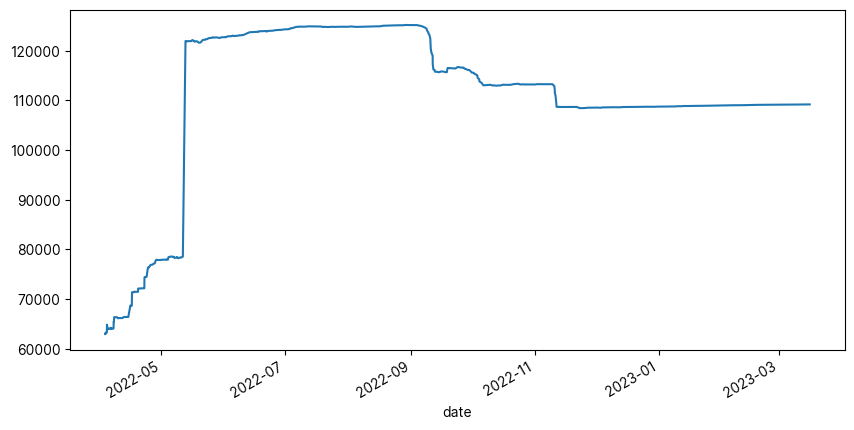

In [22]:
df['area'].plot()

In [23]:
# Show detailed view of a few days:
# df.loc["20220501":"20220515"].plot()

In [24]:
# Show n smallest areas to identify outliers
# df.loc["20230201":"20230301"].nsmallest(10, 'area')

In [25]:
df.to_csv('deepstate.csv')

In [26]:
df.to_excel('deepstate.xlsx')

In [27]:
# ipyleaflet doesn't want to show inline stuff here?
"""
def visualize_feature(feature):
    fc =   {
        'type': 'FeatureCollection',
        'features': feature,
    }
    geo_json = GeoJSON(
        data=fc,
    )
    return geo_json

geo_json= visualize_feature(process_item([0, '1648989208.json'])[3])
m = Map(center=(48.1928465, 37.8562077), zoom=5)
m.add_layer(geo_json)

m
"""

"\ndef visualize_feature(feature):\n    fc =   {\n        'type': 'FeatureCollection',\n        'features': feature,\n    }\n    geo_json = GeoJSON(\n        data=fc,\n    )\n    return geo_json\n\ngeo_json= visualize_feature(process_item([0, '1648989208.json'])[3])\nm = Map(center=(48.1928465, 37.8562077), zoom=5)\nm.add_layer(geo_json)\n\nm\n"